In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as Data  # to make Loader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import os
import numpy as np 
import time
import csv
from torchsummary import summary

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [5]:
def train(net,train_data_loader,optimizer,epoch,device):
    net.train()
    criterion=nn.CrossEntropyLoss()
    total_train_step=0
    for data in train_data_loader:
        imgs,targets=data
        imgs,targets=imgs.to(device),targets.to(device)
        #imgs=imgs.permute(0,3,1,2)
        #imgs=compose(imgs)
        outputs=net(imgs)
        optimizer.zero_grad()
        loss=criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        total_train_step+=1
        if total_train_step %160 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, total_train_step*32, len(train_data_loader)*32,
                    100. * total_train_step*32 / (len(train_data_loader)*32), loss.item()))
        
def test(net,test_data_loader,epoch,device):
    net.eval()
    acc=0
    total_acc = 0
    total_num = 0
    for batch_idx, (inputs, targets) in enumerate(test_data_loader):
        batch_size = inputs.shape[0]
        inputs=inputs.to(device)
        #inputs=compose(inputs)
        outputs = net(inputs)
        outputs=outputs.to("cpu")
        pred = np.argmax(outputs.data, axis=1)
        for i in range(len(targets.data)):
            if pred.data[i]==targets.data[i]:
                acc+=1
        total_acc += acc
        total_num += batch_size
        acc = acc / batch_size
        if batch_idx % 64 == 0:
            print('Test Epoch: {} [{}/{} ({:.0f}%)]\tAcc: {:.6f}'.format(epoch, \
                    batch_idx*batch_size, len(test_data_loader)*batch_size,100. * float(batch_idx)*batch_size / (batch_size*len(test_data_loader)), acc))
            
    print ('Total test acc =', total_acc / total_num)
    return total_acc/total_num


In [7]:
'''The target and the full set of images have completed'''
device = torch.device("cuda")
net=ResNet18().to(device)
learning_rate=1e-3
optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# 1. Get the train data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),transforms.RandomResizedCrop((32,32),antialias=True)])
train_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_data_loader = Data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    # num_workers=2 # ready to be commented(windows)
)
test_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)
test_data_loader = Data.DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    # num_workers=2
)
epochs=100
epoch=0
train_loss=[]
test_acc=[]

Files already downloaded and verified
Files already downloaded and verified


In [8]:
while epoch < epochs:
    #checkpoint=torch.load(path)
    #epoch=checkpoint['epoch']
    #if epoch > 0:
    #    #loss=checkpoint['loss']
    #    net.load_state_dict(checkpoint['model_state_dict'])
    #    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])   # load data from checkpoint if has trained.
    print("epoch: ",epoch+1)
    train_loss.append(train(net,train_data_loader,optimizer,epoch+1,device))
    test_acc.append(test(net,test_data_loader,epoch+1,device))
    scheduler.step()
    #params=net.state_dict()
    epoch+=1
    #torch.save({'epoch': epoch,'model_state_dict': net.state_dict(),'optimizer_state_dict': optimizer.state_dict()},path)

epoch:  1
Train Epoch: 1 [5120/50016 (10%)]	Loss: 1.684928
Train Epoch: 1 [10240/50016 (20%)]	Loss: 1.694371
Train Epoch: 1 [15360/50016 (31%)]	Loss: 1.723184
Train Epoch: 1 [20480/50016 (41%)]	Loss: 1.786580
Train Epoch: 1 [25600/50016 (51%)]	Loss: 1.169143
Train Epoch: 1 [30720/50016 (61%)]	Loss: 1.480228
Train Epoch: 1 [35840/50016 (72%)]	Loss: 1.556011
Train Epoch: 1 [40960/50016 (82%)]	Loss: 1.291971
Train Epoch: 1 [46080/50016 (92%)]	Loss: 1.333292
Test Epoch: 1 [0/10016 (0%)]	Acc: 0.437500
Test Epoch: 1 [2048/10016 (20%)]	Acc: 0.456525
Test Epoch: 1 [4096/10016 (41%)]	Acc: 0.333449
Test Epoch: 1 [6144/10016 (61%)]	Acc: 0.324775
Test Epoch: 1 [8192/10016 (82%)]	Acc: 0.456589
Total test acc = 0.4642827197243808
epoch:  2
Train Epoch: 2 [5120/50016 (10%)]	Loss: 1.227190
Train Epoch: 2 [10240/50016 (20%)]	Loss: 1.398421
Train Epoch: 2 [15360/50016 (31%)]	Loss: 1.431101
Train Epoch: 2 [20480/50016 (41%)]	Loss: 1.193825
Train Epoch: 2 [25600/50016 (51%)]	Loss: 1.186788
Train Epoch: 2 

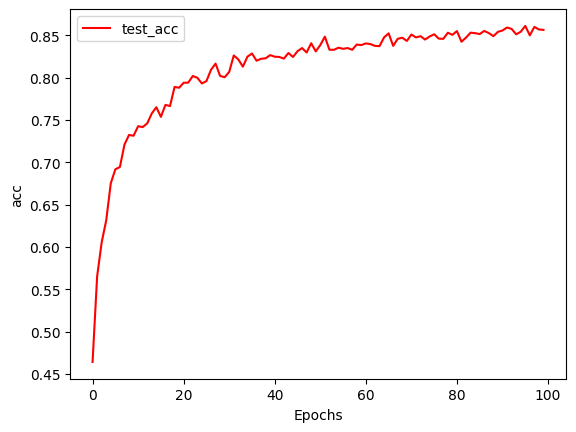

0.860961696711396

In [13]:
plt.plot(test_acc,'r',label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()
max(test_acc)